# Factorización de Semiprimos con Algoritmo de Shor
## Análisis Estadístico Separando Éxito Clásico vs Cuántico

**Objetivo:** Estudiar el rendimiento cuántico REAL del algoritmo de Shor, separando:

- **Capa A (Híbrido):** Probabilidad total incluyendo preprocesamiento clásico (MCD)
- **Capa B (Cuántico Puro):** Rendimiento condicionado a gcd(a,N)=1

### Métricas principales:
- Shots necesarios (solo para gcd(a,N)=1)
- n bits vs tasa de éxito cuántico
- Probabilidad de primer éxito en k intentos
- Clasificación de fallos (r impar, a^(r/2)≡-1, ruido)

In [1]:
# Instalación
!pip -q install pandas numpy matplotlib tqdm scipy qiskit qiskit-aer

In [2]:
import time, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, geom
from fractions import Fraction
from tqdm import tqdm

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

print("Simulador cuántico local configurado")

Simulador cuántico local configurado


In [3]:
# === CONFIGURACIÓN ===
BIT_RANGE = list(range(4, 18))  # 4 a 17 bits
M_SHOTS_LIST = [50, 100, 500, 1024, 2048, 4096]
R = 20  # Repeticiones
SEMIPRIMES_PER_SIZE = 7

DATA_DIR = "datasets"
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Bits: {BIT_RANGE[0]}-{BIT_RANGE[-1]}, Shots: {M_SHOTS_LIST}, R={R}")

Bits: 4-17, Shots: [50, 100, 500, 1024, 2048, 4096], R=20


## Generación de Semiprimos (sin sympy)

In [5]:
def is_prime(n):
    if n < 2: return False
    if n == 2: return True
    if n % 2 == 0: return False
    for i in range(3, int(math.isqrt(n)) + 1, 2):
        if n % i == 0: return False
    return True

def generate_semiprimes(n_bits, count):
    min_val, max_val = 2**(n_bits-1), 2**n_bits - 1
    
    # Umbral dinámico: bits pequeños necesitan primos pequeños
    if n_bits <= 7:
        MIN_PRIME = 3  # Necesario para tener semiprimos válidos
    elif n_bits <= 9:
        MIN_PRIME = 7  # Evitar 3, 5 pero permitir 7
    else:
        MIN_PRIME = 11  # Evitar primos muy pequeños (reduce gcd_luck)
    
    primes = [n for n in range(MIN_PRIME, max_val // 2 + 1) if is_prime(n)]
    
    semiprimes = []
    sqrt_limit = int(math.isqrt(max_val))
    
    for i, p in enumerate(primes):
        if p > sqrt_limit:
            break
        for q in primes[i:]: 
            N = p * q
            if N > max_val:
                break
            if min_val <= N <= max_val and p != q:
                ratio = max(p, q) / min(p, q)
                if ratio < 10:  # Evitar factores muy desbalanceados
                    semiprimes.append((N, p, q))
                
    np.random.shuffle(semiprimes)
    return semiprimes[:count]

test_semiprimes = {n: generate_semiprimes(n, SEMIPRIMES_PER_SIZE) for n in BIT_RANGE}
for n, sp in test_semiprimes.items():
    if sp: print(f"{n} bits: {len(sp)} semiprimos, ej: N={sp[0][0]}={sp[0][1]}×{sp[0][2]}")


4 bits: 1 semiprimos, ej: N=15=3×5
5 bits: 1 semiprimos, ej: N=21=3×7
6 bits: 6 semiprimos, ej: N=33=3×11
7 bits: 7 semiprimos, ej: N=91=7×13
8 bits: 7 semiprimos, ej: N=217=7×31
9 bits: 7 semiprimos, ej: N=301=7×43
10 bits: 7 semiprimos, ej: N=697=17×41
11 bits: 7 semiprimos, ej: N=1633=23×71
12 bits: 7 semiprimos, ej: N=2923=37×79
13 bits: 7 semiprimos, ej: N=5609=71×79
14 bits: 7 semiprimos, ej: N=12317=109×113
15 bits: 7 semiprimos, ej: N=24163=73×331
16 bits: 7 semiprimos, ej: N=51143=199×257
17 bits: 7 semiprimos, ej: N=128081=263×487


## Componentes del Algoritmo de Shor

In [6]:
def gcd(a, b):
    while b: a, b = b, a % b
    return a

def mod_exp(base, exp, mod):
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1: result = (result * base) % mod
        exp >>= 1
        base = (base * base) % mod
    return result

def qft_dagger(qc, n):
    for q in range(n//2): qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j): qc.cp(-np.pi / (2**(j-m)), m, j)
        qc.h(j)

def c_amod15(a, power):
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2,13]: U.swap(2,3); U.swap(1,2); U.swap(0,1)
        if a in [7,8]: U.swap(0,1); U.swap(1,2); U.swap(2,3)
        if a in [4,11]: U.swap(1,3); U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4): U.x(q)
    return U.to_gate().control()

print("Componentes definidos")

Componentes definidos


In [7]:
def create_shor_circuit(N, a, n_count):
    """Circuito de Shor con QPE."""
    if N == 15:
        qc = QuantumCircuit(n_count + 4, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            qc.append(c_amod15(a, 2**q), [q] + list(range(n_count, n_count+4)))
    else:
        n_aux = max(4, N.bit_length())
        qc = QuantumCircuit(n_count + n_aux, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            angle = 2 * np.pi * mod_exp(a, 2**q, N) / (2**n_count)
            qc.cp(angle, q, n_count)
    
    qft_dagger(qc, n_count)
    qc.measure(range(n_count), range(n_count))
    return qc

print("Circuito Shor definido")

Circuito Shor definido


## Algoritmo de Shor con Clasificación de Resultados

In [10]:
def shor_factor_detailed(N, shots, max_attempts=10):
    """
    Ejecuta Shor con clasificación detallada:
    - gcd_luck: éxito por MCD (clásico)
    - quantum_success: éxito cuántico real
    - fail_r_odd: r impar
    - fail_trivial: a^(r/2) ≡ ±1 mod N
    - fail_no_period: no se encontró período
    """
    t0 = time.time()
    qubits_used = 0
    
    if N % 2 == 0:
        return {'success': True, 'factors': [2, N//2], 'attempts': 0,
                'time': 0, 'qubits': 0, 'method': 'trivial_even',
                'is_quantum': False, 'fail_reason': None}
    
    for attempt in range(1, max_attempts + 1):
        a = np.random.randint(2, N - 1)
        
        # Verificar MCD (éxito clásico)
        g = gcd(a, N)
        if g > 1:
            return {'success': True, 'factors': sorted([g, N//g]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': 0, 'method': 'gcd_luck',
                    'is_quantum': False, 'fail_reason': None, 'a': a}
        
        # Ejecutar QPE cuántico
        n_count = min(12, max(4, 2 * N.bit_length()))
        qc = create_shor_circuit(N, a, n_count)
        qubits_used = qc.num_qubits

        qc_decomposed = qc.decompose()
        
        sim = AerSimulator()
        counts = sim.run(qc_decomposed, shots=shots).result().get_counts()
        
        # Buscar período
        r_found = None
        for output, cnt in sorted(counts.items(), key=lambda x: -x[1]):
            decimal = int(output, 2)
            if decimal == 0: continue
            phase = decimal / (2**n_count)
            frac = Fraction(phase).limit_denominator(N)
            r = frac.denominator
            if r > 1 and mod_exp(a, r, N) == 1:
                r_found = r
                break
        
        if r_found is None:
            continue  # fail_no_period, seguir intentando
        
        # Verificar condiciones
        if r_found % 2 != 0:
            continue  # fail_r_odd
        
        x = mod_exp(a, r_found // 2, N)
        if x == 1 or x == N - 1:
            continue  # fail_trivial: a^(r/2) ≡ ±1
        
        # Intentar factorizar
        f1, f2 = gcd(x-1, N), gcd(x+1, N)
        if 1 < f1 < N:
            return {'success': True, 'factors': sorted([f1, N//f1]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
        if 1 < f2 < N:
            return {'success': True, 'factors': sorted([f2, N//f2]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
    
    return {'success': False, 'factors': [], 'attempts': max_attempts,
            'time': time.time()-t0, 'qubits': qubits_used, 'method': 'failed',
            'is_quantum': False, 'fail_reason': 'max_attempts'}

# Test
test = shor_factor_detailed(15, 1024)
print(f"Test N=15: {test['method']}, success={test['success']}")

Test N=15: quantum_success, success=True


## Experimento Principal

In [11]:
def run_experiment():
    rows = []
    total = sum(len(test_semiprimes.get(n,[])) for n in BIT_RANGE) * len(M_SHOTS_LIST) * R
    
    with tqdm(total=total, desc="Experimento") as pbar:
        for n_bits in BIT_RANGE:
            for N, p, q in test_semiprimes.get(n_bits, []):
                for M in M_SHOTS_LIST:
                    for rep in range(1, R + 1):
                        res = shor_factor_detailed(N, shots=M)
                        rows.append({
                            'n_bits': n_bits, 'N': N, 'p_true': p, 'q_true': q,
                            'M_shots': M, 'rep': rep,
                            'success': int(res['success']),
                            'is_quantum': int(res['is_quantum']),
                            'method': res['method'],
                            'attempts': res['attempts'],
                            'time_sec': res['time'],
                            'qubits': res['qubits']
                        })
                        pbar.update(1)
    return pd.DataFrame(rows)

print("Ejecutando experimento...")
df = run_experiment()
df.to_csv(f"{DATA_DIR}/shor_experiment_v2.csv", index=False)
print(f"Guardado: {DATA_DIR}/shor_experiment_v2.csv ({len(df)} filas)")

Ejecutando experimento...


Experimento: 100%|██████████| 10200/10200 [48:22<00:00,  3.51it/s]    

Guardado: datasets/shor_experiment_v2.csv (10200 filas)


## Análisis Separado: Clásico vs Cuántico

In [12]:
def analyze_separated(df):
    total = len(df)
    gcd_luck = len(df[df['method'] == 'gcd_luck'])
    quantum_ok = len(df[df['method'] == 'quantum_success'])
    failed = len(df[df['success'] == 0])
    
    print("="*70)
    print("SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO")
    print("="*70)
    print(f"Total intentos: {total}")
    print(f"")
    print(f"  Éxito por MCD (clásico):     {gcd_luck:5d} ({100*gcd_luck/total:.1f}%)")
    print(f"  Éxito cuántico real:         {quantum_ok:5d} ({100*quantum_ok/total:.1f}%)")
    print(f"  Fracasos:                    {failed:5d} ({100*failed/total:.1f}%)")
    print("")
    print("   El éxito por MCD NO es rendimiento cuántico.")
    print("    Para análisis cuántico, usar solo casos con gcd(a,N)=1")
    
    return {'total': total, 'gcd_luck': gcd_luck, 'quantum_ok': quantum_ok, 'failed': failed}

stats = analyze_separated(df)

SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO
Total intentos: 10200

  Éxito por MCD (clásico):      4208 (41.3%)
  Éxito cuántico real:          1447 (14.2%)
  Fracasos:                     4545 (44.6%)

   El éxito por MCD NO es rendimiento cuántico.
    Para análisis cuántico, usar solo casos con gcd(a,N)=1


In [13]:
# Filtrar solo casos cuánticamente relevantes
df_quantum = df[df['method'] != 'gcd_luck'].copy()

print(f"\nAnálisis CUÁNTICO PURO (excluyendo {stats['gcd_luck']} casos de MCD):")
print(f"Casos analizados: {len(df_quantum)}")

# Tasa de éxito cuántico por n_bits
q_by_bits = df_quantum.groupby('n_bits')['success'].mean()
print("\n" + "="*50)
print("n BITS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for n, rate in q_by_bits.items():
    print(f"  {n:2d} bits: {rate:.4f} ({rate*100:.1f}%)")


Análisis CUÁNTICO PURO (excluyendo 4208 casos de MCD):
Casos analizados: 5992

n BITS vs TASA DE ÉXITO CUÁNTICO
   4 bits: 1.0000 (100.0%)
   5 bits: 1.0000 (100.0%)
   6 bits: 0.9605 (96.1%)
   7 bits: 0.7740 (77.4%)
   8 bits: 0.5140 (51.4%)
   9 bits: 0.5944 (59.4%)
  10 bits: 0.6226 (62.3%)
  11 bits: 0.4971 (49.7%)
  12 bits: 0.4501 (45.0%)
  13 bits: 0.0325 (3.3%)
  14 bits: 0.0132 (1.3%)
  15 bits: 0.0070 (0.7%)
  16 bits: 0.0213 (2.1%)
  17 bits: 0.0026 (0.3%)


In [14]:
# Tasa de éxito cuántico por SHOTS
q_by_shots = df_quantum.groupby('M_shots')['success'].mean()

print("\n" + "="*50)
print("SHOTS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for shots, rate in q_by_shots.items():
    print(f"  {shots:5d} shots: {rate:.4f} ({rate*100:.1f}%)")


SHOTS vs TASA DE ÉXITO CUÁNTICO
     50 shots: 0.1254 (12.5%)
    100 shots: 0.1547 (15.5%)
    500 shots: 0.2196 (22.0%)
   1024 shots: 0.2701 (27.0%)
   2048 shots: 0.3189 (31.9%)
   4096 shots: 0.3330 (33.3%)


## Tablas de Frecuencia con Clasificación de Fallos

In [15]:
def frequency_table(df):
    print("\n" + "="*70)
    print("TABLA DE FRECUENCIA POR MÉTODO")
    print("="*70)
    
    methods = df['method'].value_counts()
    for method, count in methods.items():
        pct = 100 * count / len(df)
        label = {
            'gcd_luck': '  Éxito clásico (MCD)',
            'quantum_success': '  Éxito cuántico',
            'failed': '  Fracaso (agotó intentos)',
            'trivial_even': '  N par (trivial)'
        }.get(method, method)
        print(f"  {label:30s}: {count:5d} ({pct:.1f}%)")
    
    # Por n_bits
    print("\n" + "-"*70)
    print("Desglose por n_bits:")
    pivot = pd.crosstab(df['n_bits'], df['method'], margins=True)
    print(pivot.to_string())

frequency_table(df)


TABLA DE FRECUENCIA POR MÉTODO
    Fracaso (agotó intentos)    :  4545 (44.6%)
    Éxito clásico (MCD)         :  4208 (41.3%)
    Éxito cuántico              :  1447 (14.2%)

----------------------------------------------------------------------
Desglose por n_bits:
method  failed  gcd_luck  quantum_success    All
n_bits                                          
4            0        61               59    120
5            0       104               16    120
6            3       644               73    720
7           33       694              113    840
8          104       626              110    840
9          144       485              211    840
10         180       363              297    840
11         261       321              258    840
12         314       269              257    840
13         625       194               21    840
14         672       159                9    840
15         708       127                5    840
16         736        88               16    

In [16]:
def quantum_vs_failed_table(df):
    """Tabla comparativa explícita: Éxitos Cuánticos vs Fracasos"""
    print("\n" + "="*70)
    print("TABLA COMPARATIVA: ÉXITOS CUÁNTICOS vs FRACASOS")
    print("="*70)
    
    # Solo casos relevantes (excluyendo gcd_luck)
    df_pure = df[df['method'] != 'gcd_luck'].copy()
    
    quantum_ok = len(df_pure[df_pure['method'] == 'quantum_success'])
    failed = len(df_pure[df_pure['method'] == 'failed'])
    total = quantum_ok + failed
    
    print(f"\nCasos sin intervención de MCD (análisis cuántico puro): {total}")
    print(f"  Éxitos cuánticos:  {quantum_ok:5d} ({100*quantum_ok/total:.1f}%)")
    print(f"  Fracasos:          {failed:5d} ({100*failed/total:.1f}%)")
    if failed > 0:
        print(f"  Razón éxito/fallo: {quantum_ok/failed:.2f}")
    
    # Desglose por n_bits
    print("\n" + "-"*70)
    print("Desglose por número de bits (solo cuántico vs fracasos):")
    print("-"*70)
    print(f"{'n_bits':>7} | {'Cuántico':>10} | {'Fracasos':>10} | {'Tasa Éxito':>12}")
    print("-"*70)
    
    for n in sorted(df_pure['n_bits'].unique()):
        df_n = df_pure[df_pure['n_bits'] == n]
        q = len(df_n[df_n['method'] == 'quantum_success'])
        f = len(df_n[df_n['method'] == 'failed'])
        rate = q / (q + f) if (q + f) > 0 else 0
        print(f"{n:>7} | {q:>10} | {f:>10} | {rate:>11.1%}")
    
    return df_pure

# Ejecutar
quantum_vs_failed_table(df)


TABLA COMPARATIVA: ÉXITOS CUÁNTICOS vs FRACASOS

Casos sin intervención de MCD (análisis cuántico puro): 5992
  Éxitos cuánticos:   1447 (24.1%)
  Fracasos:           4545 (75.9%)
  Razón éxito/fallo: 0.32

----------------------------------------------------------------------
Desglose por número de bits (solo cuántico vs fracasos):
----------------------------------------------------------------------
 n_bits |   Cuántico |   Fracasos |   Tasa Éxito
----------------------------------------------------------------------
      4 |         59 |          0 |      100.0%
      5 |         16 |          0 |      100.0%
      6 |         73 |          3 |       96.1%
      7 |        113 |         33 |       77.4%
      8 |        110 |        104 |       51.4%
      9 |        211 |        144 |       59.4%
     10 |        297 |        180 |       62.3%
     11 |        258 |        261 |       49.7%
     12 |        257 |        314 |       45.0%
     13 |         21 |        625 |      

,n_bits,N,p_true,q_true,M_shots,rep,success,is_quantum,method,attempts,time_sec,qubits
1,4,15,3,5,50,2,1,1,quantum_success,1,0.107499,12
2,4,15,3,5,50,3,1,1,quantum_success,1,0.121045,12
4,4,15,3,5,50,5,1,1,quantum_success,1,0.121992,12
5,4,15,3,5,50,6,1,1,quantum_success,1,0.150543,12
6,4,15,3,5,50,7,1,1,quantum_success,1,0.133328,12
...,...,...,...,...,...,...,...,...,...,...,...,...
10195,17,109699,163,673,4096,16,0,0,failed,10,0.501475,29
10196,17,109699,163,673,4096,17,0,0,failed,10,0.501987,29
10197,17,109699,163,673,4096,18,0,0,failed,10,0.502283,29
10198,17,109699,163,673,4096,19,0,0,failed,10,0.494051,29


## Probabilidad de Primer Éxito en k Intentos

In [17]:
def analyze_attempts_quantum(df):
    """Análisis de intentos usando SOLO probabilidad cuántica."""
    df_q = df[df['method'] != 'gcd_luck']
    
    print("\n" + "="*70)
    print("INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)")
    print("="*70)
    print("Fórmula: P(éxito ≤ k) = 1 - (1-p)^k")
    print("")
    
    results = []
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if 0 < p < 1:
            k95 = int(np.ceil(np.log(0.05) / np.log(1-p)))
            k99 = int(np.ceil(np.log(0.01) / np.log(1-p)))
        elif p == 1:
            k95 = k99 = 1
        else:
            k95 = k99 = float('inf')
        
        results.append({'n_bits': n_bits, 'p_quantum': p, 'k_95%': k95, 'k_99%': k99})
        print(f"{n_bits:2d} bits: p̂={p:.4f} → 95%: {k95} intentos, 99%: {k99} intentos")
    
    return pd.DataFrame(results)

df_attempts = analyze_attempts_quantum(df)


INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)
Fórmula: P(éxito ≤ k) = 1 - (1-p)^k

 4 bits: p̂=1.0000 → 95%: 1 intentos, 99%: 1 intentos
 5 bits: p̂=1.0000 → 95%: 1 intentos, 99%: 1 intentos
 6 bits: p̂=0.9605 → 95%: 1 intentos, 99%: 2 intentos
 7 bits: p̂=0.7740 → 95%: 3 intentos, 99%: 4 intentos
 8 bits: p̂=0.5140 → 95%: 5 intentos, 99%: 7 intentos
 9 bits: p̂=0.5944 → 95%: 4 intentos, 99%: 6 intentos
10 bits: p̂=0.6226 → 95%: 4 intentos, 99%: 5 intentos
11 bits: p̂=0.4971 → 95%: 5 intentos, 99%: 7 intentos
12 bits: p̂=0.4501 → 95%: 6 intentos, 99%: 8 intentos
13 bits: p̂=0.0325 → 95%: 91 intentos, 99%: 140 intentos
14 bits: p̂=0.0132 → 95%: 226 intentos, 99%: 347 intentos
15 bits: p̂=0.0070 → 95%: 426 intentos, 99%: 655 intentos
16 bits: p̂=0.0213 → 95%: 140 intentos, 99%: 215 intentos
17 bits: p̂=0.0026 → 95%: 1148 intentos, 99%: 1764 intentos


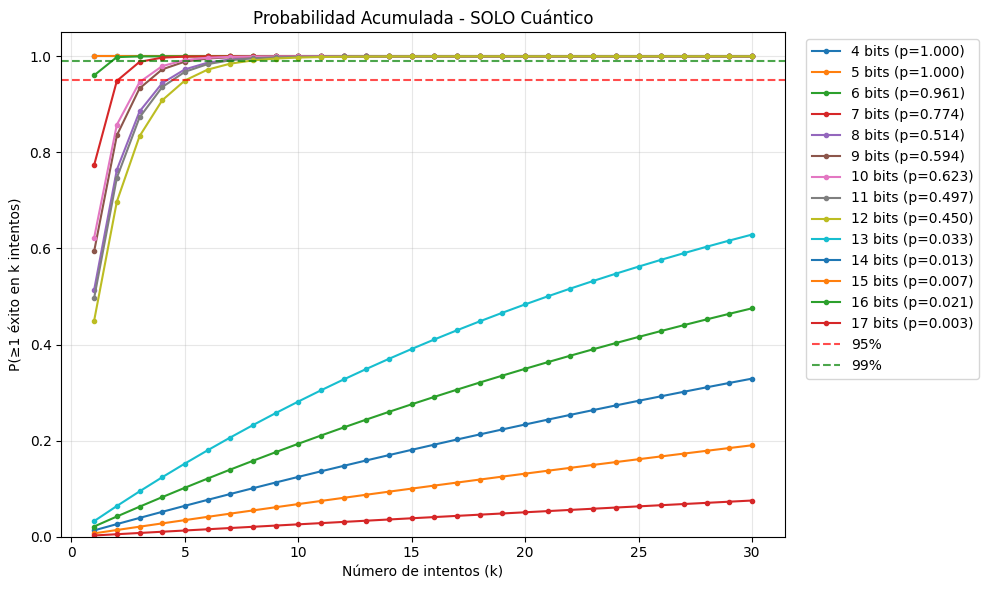

In [18]:
# Gráfica de probabilidad acumulada
def plot_cumulative(df):
    df_q = df[df['method'] != 'gcd_luck']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    k_range = range(1, 31)
    
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if p > 0:
            cum = [1 - (1-p)**k for k in k_range]
            ax.plot(k_range, cum, 'o-', markersize=3, label=f'{n_bits} bits (p={p:.3f})')
    
    ax.axhline(0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    ax.axhline(0.99, color='g', linestyle='--', alpha=0.7, label='99%')
    ax.set_xlabel('Número de intentos (k)')
    ax.set_ylabel('P(≥1 éxito en k intentos)')
    ax.set_title('Probabilidad Acumulada - SOLO Cuántico')
    ax.legend(bbox_to_anchor=(1.02, 1))
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/cumulative_quantum.png", dpi=150)
    plt.show()

plot_cumulative(df)

## Distribuciones: Geométrica vs Gaussiana

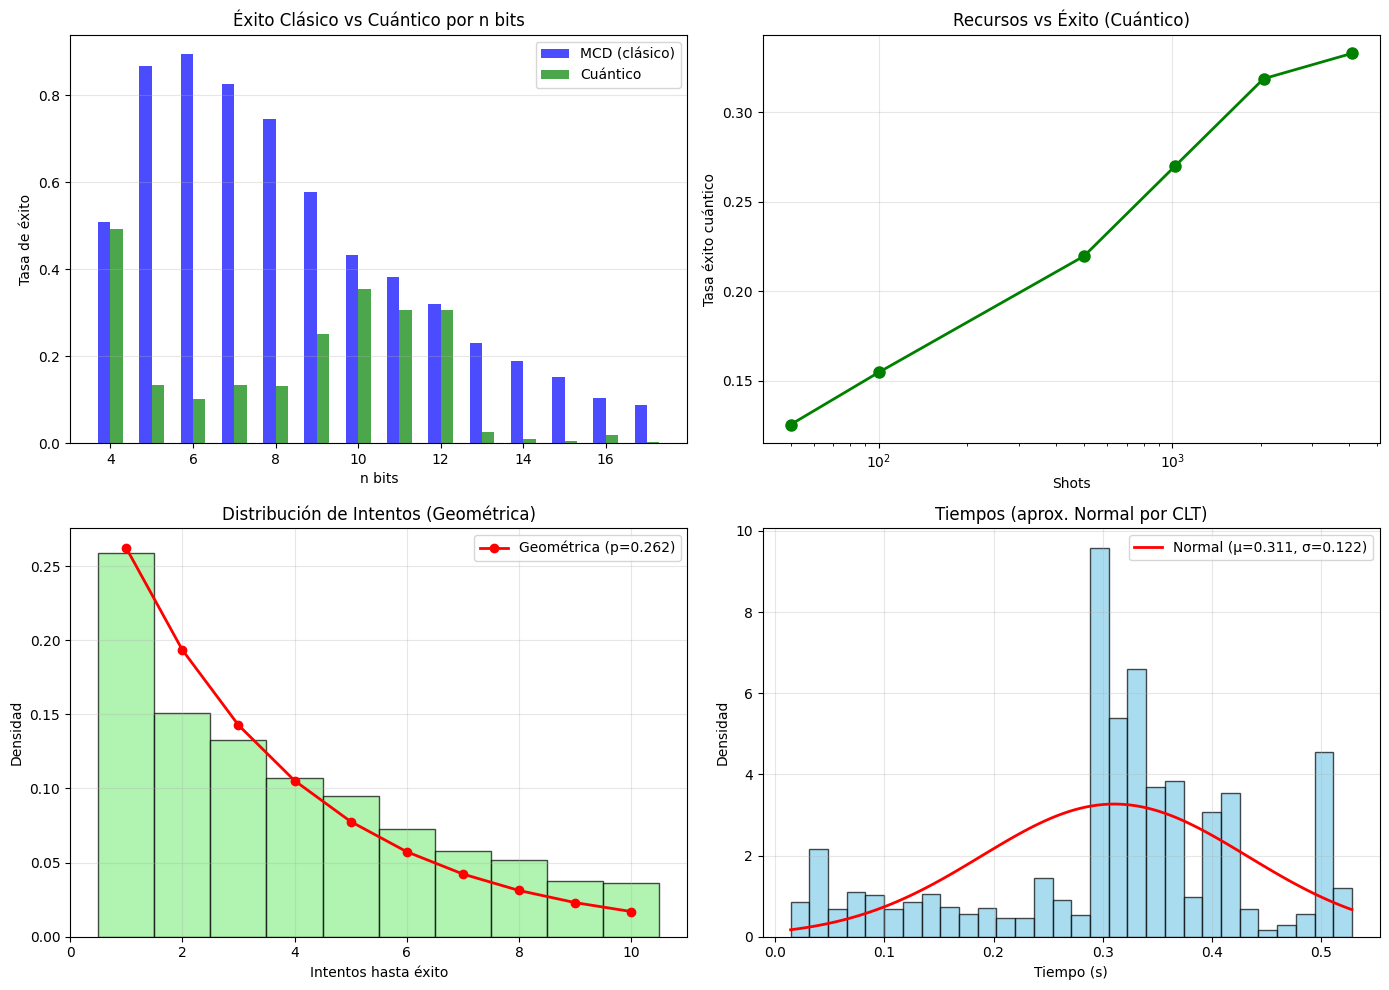

In [19]:
def analyze_distributions(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. n bits vs tasa de éxito (separado)
    ax = axes[0, 0]
    by_bits_gcd = df[df['method']=='gcd_luck'].groupby('n_bits').size() / df.groupby('n_bits').size()
    by_bits_q = df[df['method']=='quantum_success'].groupby('n_bits').size() / df.groupby('n_bits').size()
    
    x = sorted(df['n_bits'].unique())
    ax.bar([i-0.15 for i in x], [by_bits_gcd.get(i,0) for i in x], 0.3, label='MCD (clásico)', color='blue', alpha=0.7)
    ax.bar([i+0.15 for i in x], [by_bits_q.get(i,0) for i in x], 0.3, label='Cuántico', color='green', alpha=0.7)
    ax.set_xlabel('n bits')
    ax.set_ylabel('Tasa de éxito')
    ax.set_title('Éxito Clásico vs Cuántico por n bits')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Shots vs tasa (solo cuántico)
    ax = axes[0, 1]
    df_q = df[df['method'] != 'gcd_luck']
    by_shots = df_q.groupby('M_shots')['success'].mean()
    ax.plot(by_shots.index, by_shots.values, 'go-', linewidth=2, markersize=8)
    ax.set_xlabel('Shots')
    ax.set_ylabel('Tasa éxito cuántico')
    ax.set_title('Recursos vs Éxito (Cuántico)')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # 3. Distribución de intentos (geométrica)
    ax = axes[1, 0]
    success_df = df_q[df_q['success']==1]
    if len(success_df) > 0:
        attempts = success_df['attempts'].values
        ax.hist(attempts, bins=range(1,12), density=True, alpha=0.7, color='lightgreen', edgecolor='black', align='left')
        
        p_est = 1/attempts.mean() if len(attempts)>0 else 0.5
        x = np.arange(1, 11)
        ax.plot(x, geom.pmf(x, p_est), 'r-o', linewidth=2, label=f'Geométrica (p={p_est:.3f})')
        ax.legend()
    ax.set_xlabel('Intentos hasta éxito')
    ax.set_ylabel('Densidad')
    ax.set_title('Distribución de Intentos (Geométrica)')
    ax.grid(True, alpha=0.3)
    
    # 4. Tiempos (aproximación normal por CLT)
    ax = axes[1, 1]
    times = df_q['time_sec'].values
    times = times[times < np.percentile(times, 99)]
    ax.hist(times, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, std = norm.fit(times)
    x = np.linspace(times.min(), times.max(), 100)
    ax.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Normal (μ={mu:.3f}, σ={std:.3f})')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.set_title('Tiempos (aprox. Normal por CLT)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/distributions_v2.png", dpi=150)
    plt.show()

analyze_distributions(df)

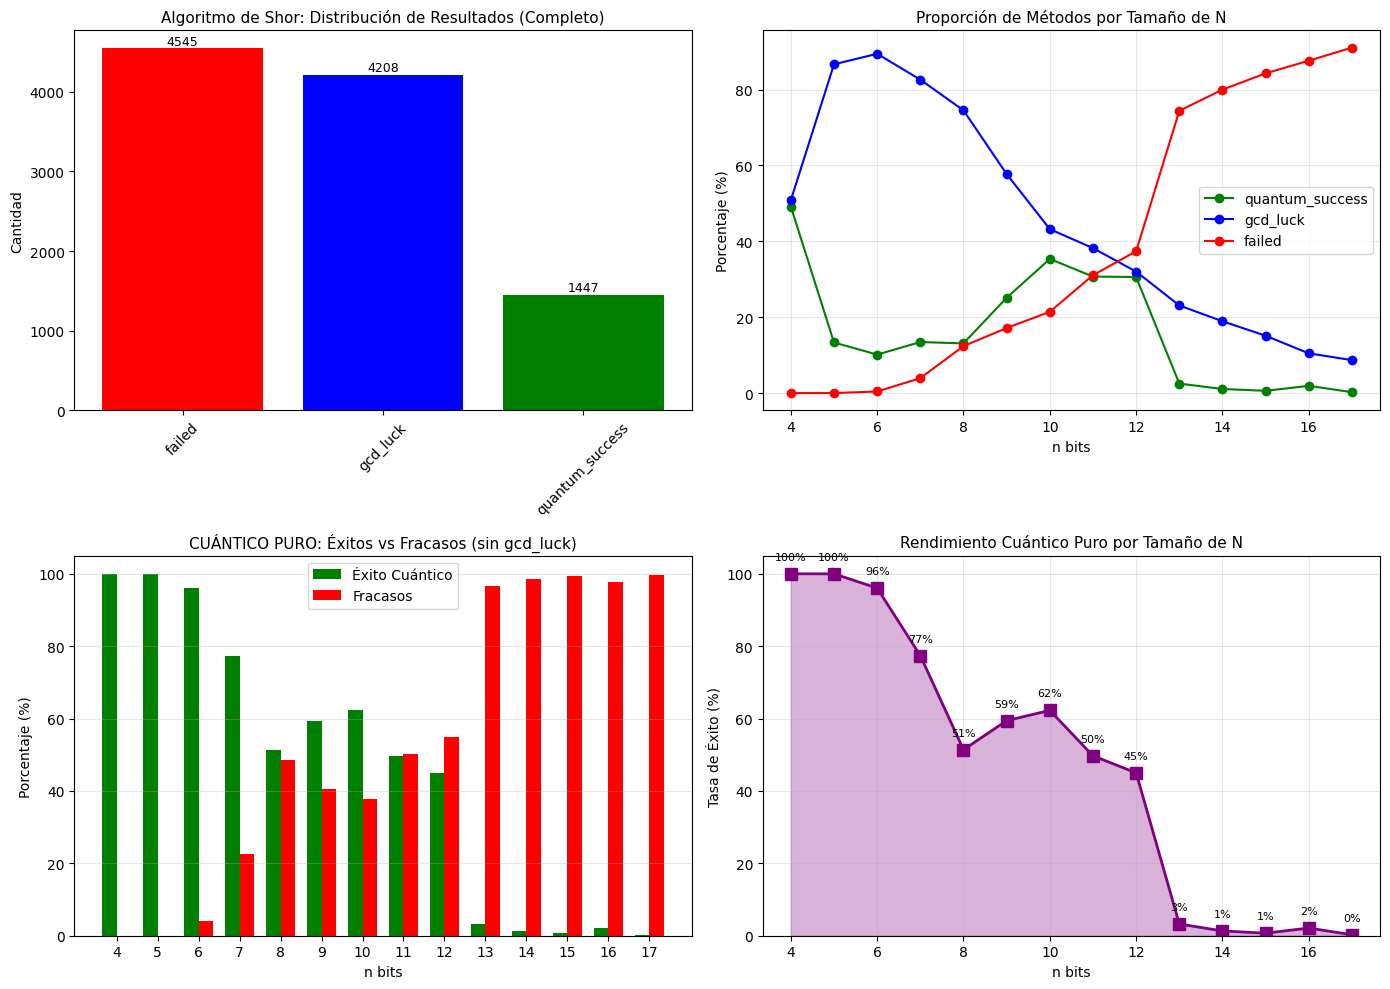


Guardado: datasets/quantum_analysis.png


In [20]:
def plot_quantum_analysis(df):
    """Gráficas separadas para análisis cuántico completo"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ===== GRÁFICA 1: Análisis Completo de Shor (con todos los métodos) =====
    ax1 = axes[0, 0]
    methods_count = df['method'].value_counts()
    colors_map = {'quantum_success': 'green', 'gcd_luck': 'blue', 'failed': 'red'}
    colors = [colors_map.get(m, 'gray') for m in methods_count.index]
    bars1 = ax1.bar(methods_count.index, methods_count.values, color=colors)
    ax1.set_title('Algoritmo de Shor: Distribución de Resultados (Completo)', fontsize=11)
    ax1.set_ylabel('Cantidad')
    ax1.tick_params(axis='x', rotation=45)
    for bar, val in zip(bars1, methods_count.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 str(val), ha='center', va='bottom', fontsize=9)
    
    # ===== GRÁFICA 2: Proporción de Métodos por Bits =====
    ax2 = axes[0, 1]
    bits = sorted(df['n_bits'].unique())
    for method, color in [('quantum_success', 'green'), ('gcd_luck', 'blue'), ('failed', 'red')]:
        rates = []
        for n in bits:
            df_n = df[df['n_bits'] == n]
            rate = len(df_n[df_n['method'] == method]) / len(df_n) * 100 if len(df_n) > 0 else 0
            rates.append(rate)
        ax2.plot(bits, rates, marker='o', label=method, color=color)
    ax2.set_xlabel('n bits')
    ax2.set_ylabel('Porcentaje (%)')
    ax2.set_title('Proporción de Métodos por Tamaño de N', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ===== GRÁFICA 3: Cuántico Puro - Éxitos vs Fracasos (sin gcd_luck) =====
    ax3 = axes[1, 0]
    df_pure = df[df['method'] != 'gcd_luck']
    bits = sorted(df_pure['n_bits'].unique())
    quantum_rates = []
    failed_rates = []
    for n in bits:
        df_n = df_pure[df_pure['n_bits'] == n]
        total = len(df_n)
        if total > 0:
            quantum_rates.append(len(df_n[df_n['method'] == 'quantum_success']) / total * 100)
            failed_rates.append(len(df_n[df_n['method'] == 'failed']) / total * 100)
        else:
            quantum_rates.append(0)
            failed_rates.append(0)
    
    x = np.arange(len(bits))
    width = 0.35
    bars_q = ax3.bar(x - width/2, quantum_rates, width, label='Éxito Cuántico', color='green')
    bars_f = ax3.bar(x + width/2, failed_rates, width, label='Fracasos', color='red')
    ax3.set_xlabel('n bits')
    ax3.set_ylabel('Porcentaje (%)')
    ax3.set_title('CUÁNTICO PURO: Éxitos vs Fracasos (sin gcd_luck)', fontsize=11)
    ax3.set_xticks(x)
    ax3.set_xticklabels(bits)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ===== GRÁFICA 4: Evolución de Tasa de Éxito Cuántico Puro =====
    ax4 = axes[1, 1]
    success_rates = []
    for n in bits:
        df_n = df_pure[df_pure['n_bits'] == n]
        rate = df_n['success'].mean() * 100 if len(df_n) > 0 else 0
        success_rates.append(rate)
    
    ax4.plot(bits, success_rates, marker='s', color='purple', linewidth=2, markersize=8)
    ax4.fill_between(bits, success_rates, alpha=0.3, color='purple')
    ax4.set_xlabel('n bits')
    ax4.set_ylabel('Tasa de Éxito (%)')
    ax4.set_title('Rendimiento Cuántico Puro por Tamaño de N', fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 105)
    
    # Añadir valores en los puntos
    for i, (b, r) in enumerate(zip(bits, success_rates)):
        ax4.annotate(f'{r:.0f}%', (b, r), textcoords="offset points", 
                     xytext=(0, 10), ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/quantum_analysis.png", dpi=150)
    plt.show()
    print(f"\nGuardado: {DATA_DIR}/quantum_analysis.png")

# Ejecutar
plot_quantum_analysis(df)

## Límites de Simulación Clásica

In [21]:
def classical_limits():
    print("\n" + "="*70)
    print("LÍMITES DE SIMULACIÓN CUÁNTICA EN PC")
    print("="*70)
    print("\nQubits necesarios para Shor: ~2n + 3")
    print("Memoria: 2^qubits × 16 bytes\n")
    
    for n_bits in [4, 8, 12, 16, 20, 24, 28, 32]:
        qubits = 2*n_bits + 3
        mem_gb = (2**qubits) * 16 / (1024**3)
        status = '✓' if mem_gb < 16 else ('~' if mem_gb < 64 else '✗')
        print(f"  {n_bits:2d} bits → {qubits:2d} qubits → {mem_gb:12.2f} GB {status}")
    
    print("\n" + "-"*70)
    print("Comparación con factorización clásica:")
    print("  128 bits: trivial (microsegundos)")
    print("  512 bits: segundos")
    print(" 1024 bits: minutos")
    print(" 2048 bits: horas (RSA estándar)")
    print("\n   La simulación cuántica está limitada a ~12-14 bits en PCs típicos")
    print("    mientras que clásico factoriza miles de bits sin problema.")

classical_limits()


LÍMITES DE SIMULACIÓN CUÁNTICA EN PC

Qubits necesarios para Shor: ~2n + 3
Memoria: 2^qubits × 16 bytes

   4 bits → 11 qubits →         0.00 GB ✓
   8 bits → 19 qubits →         0.01 GB ✓
  12 bits → 27 qubits →         2.00 GB ✓
  16 bits → 35 qubits →       512.00 GB ✗
  20 bits → 43 qubits →    131072.00 GB ✗
  24 bits → 51 qubits →  33554432.00 GB ✗
  28 bits → 59 qubits → 8589934592.00 GB ✗
  32 bits → 67 qubits → 2199023255552.00 GB ✗

----------------------------------------------------------------------
Comparación con factorización clásica:
  128 bits: trivial (microsegundos)
  512 bits: segundos
 1024 bits: minutos
 2048 bits: horas (RSA estándar)

   La simulación cuántica está limitada a ~12-14 bits en PCs típicos
    mientras que clásico factoriza miles de bits sin problema.


## Resumen Final

In [ ]:
def final_summary(df):
    df_q = df[df['method'] != 'gcd_luck']
    
    print("\n" + "="*70)
    print("RESUMEN FINAL DEL EXPERIMENTO")
    print("="*70)
    
    print(f"\n  Datos totales: {len(df)} ejecuciones")
    print(f"   - Éxito por MCD (clásico): {len(df[df['method']=='gcd_luck'])}")
    print(f"   - Éxito cuántico real: {len(df[df['method']=='quantum_success'])}")
    print(f"   - Fracasos: {len(df[df['success']==0])}")
    
    print(f"\n  Métricas cuánticas (excluyendo MCD):")
    print(f"   - Tasa éxito global: {df_q['success'].mean():.4f}")
    print(f"   - Tiempo promedio: {df_q['time_sec'].mean():.4f}s")
    
    print(f"\n  Archivos generados:")
    print(f"   - {DATA_DIR}/shor_experiment_v2.csv")
    print(f"   - {DATA_DIR}/cumulative_quantum.png")
    print(f"   - {DATA_DIR}/distributions_v2.png")
    
    print("\n" + "="*70)
    print("CONCLUSIÓN")
    print("="*70)
    print("El éxito por MCD representa preprocesamiento clásico y disminuye")
    print("con N grandes. El rendimiento cuántico real debe medirse solo")
    print("sobre casos donde gcd(a,N)=1, que es el núcleo del algoritmo.")

final_summary(df)


RESUMEN FINAL DEL EXPERIMENTO

  Datos totales: 10200 ejecuciones
   - Éxito por MCD (clásico): 4208
   - Éxito cuántico real: 1447
   - Fracasos: 4545

  Métricas cuánticas (excluyendo MCD):
   - Tasa éxito global: 0.2415
   - Tiempo promedio: 0.4150s

  Archivos generados:
   - datasets/shor_experiment_v2.csv
   - datasets/cumulative_quantum.png
   - datasets/distributions_v2.png

CONCLUSIÓN
El éxito por MCD representa preprocesamiento clásico y disminuye
con N grandes. El rendimiento cuántico real debe medirse solo
sobre casos donde gcd(a,N)=1, que es el núcleo del algoritmo.


: 